In [2]:
import numpy as np
import osqp
import matplotlib.pyplot as plt
from scipy import sparse
# import control as ct
from casadi import *
import dpilqr
import itertools
import cvxpy as cp
from solvers import util
from time import perf_counter

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from solvers.util import (
    compute_pairwise_distance,
    compute_pairwise_distance_nd_Sym,
    define_inter_graph_threshold,
    distance_to_goal,
    split_graph, 
    generate_f,
    generate_f_human_drone,
    objective,
    generate_min_max_input,
    generate_min_max_state
)

In [53]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = np.zeros((6*n_agent, 6*n_agent))
    B_tot = np.zeros((6*n_agent, 3*n_agent))
    A = np.array([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = np.array([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot

In [176]:
"""Define constants"""
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x_dims = [n_states]*n_agents
n_dims = [3]*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 8
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*sparse.eye(N*n_inputs)
radius = 0.3
Ad, Bd = linear_kinodynamics(0.1, N)

In [177]:
x0.shape

(18, 1)

In [247]:
#open-loop rollout of dynamics
x_nominal = x0
# u_init = np.array([0, 0, 0]*N)
u_init = np.random.rand(3*N)*0.1
x_trj_init = np.zeros((0, nx))
x_trj_init = np.r_[x_trj_init, x0.reshape(1,-1)]
for _ in range(T):
    x_nominal = Ad@x_nominal + Bd@u_init.reshape(-1,1)
    x_trj_init = np.r_[x_trj_init, x_nominal.reshape(1,-1)]

In [248]:
scaling_matrix = np.diag([1, 1, 2])

In [249]:
iter = 0
solve_times = []
cost = 0
y_state = cp.Variable((((T+1)*nx + T * nu, 1)))
for t in range(T):
    #Quadratic tracking cost
    # cost += cp.quad_form(cp.reshape(y_state[:(T+1)*nx],[T+1, nx])[t,:]-xr.flatten(),Q) + \
    # cp.quad_form(cp.reshape(y_state[(T+1)*nx:], [T, nu])[t,:],R)
    cost += cp.quad_form(y_state[:(T+1)*nx][t*nx:(t+1)*nx]-xr, Q) + \
    cp.quad_form(y_state[(T+1)*nx:][t*nu:(t+1)*nu], R)

cost += cp.quad_form(y_state[:(T+1)*nx][T*nx:(T+1)*nx]-xr, Qf)  

X_full = np.zeros((0, nx))
X_full = np.r_[X_full, x0.reshape(1,-1)]
U_full = np.zeros((0, nu))
x_init = cp.Parameter((nx, 1))
x_curr = x0
while not np.all(dpilqr.distance_to_goal(x_curr, xr, N, 6, 3) <= 0.1):
    constr = []
    for k in range(T):
        constr += [y_state[0:nx] == x_init]
        constr += [y_state[:(T+1)*nx][(k+1)*nx:(k+2)*nx] \
                    == Ad @ y_state[:(T+1)*nx][k*nx:(k+1)*nx] \
                        + Bd @ y_state[(T+1)*nx:][k*nu:(k+1)*nu]]  
            
        constr += [y_state[(T+1)*nx:][k*nu:(k+1)*nu]<= np.tile(np.array([3, 3, 3]),(N,)).reshape(-1,1)]
        constr += [np.tile(np.array([-3, -3, -3]),(N,)).reshape(-1,1) <= y_state[(T+1)*nu:][k*nu:(k+1)*nu]]
        
        constr += [y_state[:(T+1)*nx][k*nx:(k+1)*nx]<= np.tile(np.array([3, 3, 3, 2, 2, 2]),(N,)).reshape(-1,1)]
        constr += [np.tile(np.array([-3, -3, 0, -2, -2, -2]),(N,)).reshape(-1,1) <= y_state[:(T+1)*nx][k*nx:(k+1)*nx]]
        
        if N > 1:
            if iter <= 0:
                pos_prev = x_trj_init[k]
            
            else:
                pos_prev = state_prev[:(T+1)*nx].reshape(T+1, nx)[k]
                # pos_prev = X_full[iter-1]
                # pos_curr = cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[k]
            
            for i in range(N):
                for j in range(N):
                    if j != i:
                        #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                        # A sequential convex programming approach" for the linearization step;
                        linearized_dist = cp.norm(scaling_matrix @ (pos_prev[j*n_states:j*n_states+3]-  \
                            pos_prev[i*n_states:i*n_states+3])) + \
                                (pos_prev[j*n_states:j*n_states+3].T- \
                                pos_prev[i*n_states:i*n_states+3].T)/cp.norm(scaling_matrix @ (pos_prev[j*n_states:j*n_states+3]\
                                -pos_prev[i*n_states:i*n_states+3]))@  \
                                (y_state[:(T+1)*nx][k*nx:(k+1)*nx][j*n_states:j*n_states+3] \
                                -y_state[:(T+1)*nx][k*nx:(k+1)*nx][i*n_states:i*n_states+3])
                        constr += [linearized_dist >= radius]

    prox = cp.Problem(cp.Minimize(cost),constr)
    t0 = perf_counter()
    x_init.value = x_curr
    prox.solve(verbose=True, warm_start=True)
    solve_times.append(perf_counter() - t0)
    state_prev = y_state.value
    
    # x_curr = y_state.value[:(T+1)*nx].reshape(T+1,nx)[1]
    u_curr = y_state.value[(T+1)*nx:].reshape(T,nu)[0]
    x_curr = Ad@x_curr + Bd@u_curr.reshape(-1,1)
    
    X_full = np.r_[X_full, x_curr.reshape(1,-1)]
    U_full = np.r_[U_full, u_curr.reshape(1,-1)]
    
    # state_prev = xbar.value[:(T+1)*nx].reshape((T+1, nx))
    iter += 1
    print(f'Current iteration is {iter}')

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 16 05:13:42 PM: Your problem has 234 variables, 96 constraints, and 18 parameters.
(CVXPY) Jul 16 05:13:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 16 05:13:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 16 05:13:42 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 16 05:13:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Jul 16 05:13:42 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 16 05:13:42 PM: Applying reduction CvxAttr2Constr
(CVXP

In [250]:
X_full.shape

(20, 18)

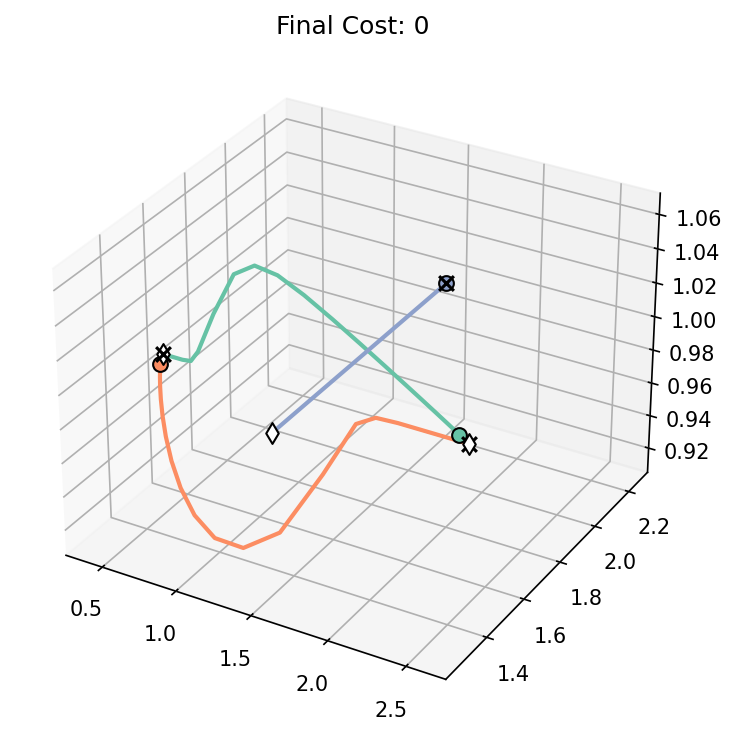

In [251]:
plt.figure(dpi=150)
dpilqr.plot_solve(X_full, 0, xr, x_dims, True, 3);

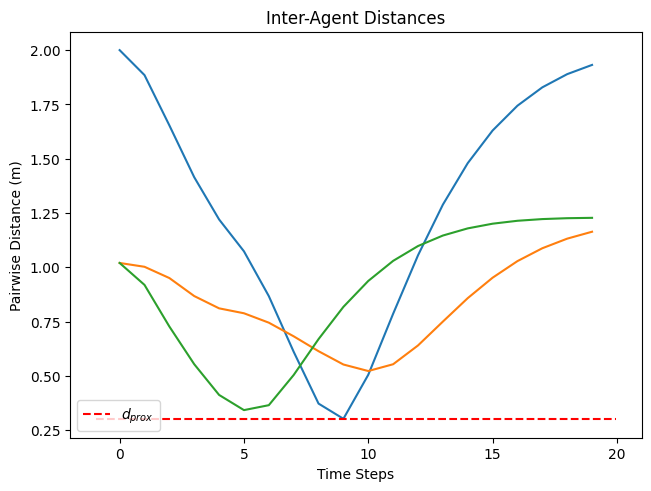

In [252]:
plt.figure(dpi=100)
dpilqr.plot_pairwise_distances(X_full,x_dims,[3]*N,radius)

In [207]:
np.mean(solve_times)

0.2104409633106307

In [208]:
np.std(solve_times)

0.03933238482348591